In [1]:
!pip install googletrans==3.1.0a0
!pip install sastrawi

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16353 sha256=18641ae1416d6d79f1ddbac3a6c5f4717937c4fa55240f81cea6a30b42d645be
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
 

In [2]:
import re
import string
import csv
import nltk
import requests
import textblob
import googletrans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from textblob import TextBlob
from googletrans import Translator
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
Reiew_MYICON= pd.read_csv('dataopiniRL.csv', sep=';')

In [4]:
# Data Processing

In [5]:
# Membersikan dan Membuat DataFrame (youtubeComment_df(yc_df))
clean_yc_df = Reiew_MYICON.dropna()


In [6]:
# Cek tipe data dari setiap kolom
print(clean_yc_df.dtypes)

author          object
authorUrl       object
like_count     float64
textComment     object
dtype: object


In [7]:
# Cek apakah ada data dict atau list dalam kolom object
for col in clean_yc_df.select_dtypes(include=['object']).columns:
    unique_types = clean_yc_df[col].apply(type).unique()
    print(f"Kolom {col} memiliki tipe data: {unique_types}")


Kolom author memiliki tipe data: [<class 'str'>]
Kolom authorUrl memiliki tipe data: [<class 'str'>]
Kolom textComment memiliki tipe data: [<class 'str'>]


In [8]:
# Mengonversi semua kolom dengan tipe dict atau list menjadi string
clean_yc_df = clean_yc_df.applymap(lambda x: str(x) if isinstance(x, (dict, list)) else x)

# Sekarang coba lagi drop_duplicates
yc_df = clean_yc_df.drop_duplicates()

# Mengecek hasil
print(yc_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 2952 entries, 0 to 3021
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   author       2952 non-null   object 
 1   authorUrl    2952 non-null   object 
 2   like_count   2952 non-null   float64
 3   textComment  2952 non-null   object 
dtypes: float64(1), object(3)
memory usage: 115.3+ KB
None


<ipython-input-8-d1e0c3d244ca>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  clean_yc_df = clean_yc_df.applymap(lambda x: str(x) if isinstance(x, (dict, list)) else x)


In [9]:

# Membersikan baris yang sama dari DataFrame (youtubeComment_df(yc_df))
yc_df = clean_yc_df.drop_duplicates()

# jumlah komentar dan kolom setealh dihapus
new_sum_of_comment, new_sum_of_column = yc_df.shape


yc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2952 entries, 0 to 3021
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   author       2952 non-null   object 
 1   authorUrl    2952 non-null   object 
 2   like_count   2952 non-null   float64
 3   textComment  2952 non-null   object 
dtypes: float64(1), object(3)
memory usage: 115.3+ KB


In [10]:
# 3. Preprocessing Text

In [11]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [12]:
# 3.1. Membersihkan teks komentar

In [13]:
def textCleaning(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

In [14]:
# 3.2 Mengubah semua karakter dalam teks menjadi huruf kecil

In [15]:
def textCasefolding(text):
    text = text.lower()
    return text

In [16]:
# 3.3. Membagi teks string menjadi daftar token

In [17]:
def textTokenizing(text):
    text = word_tokenize(text)
    return text

In [18]:
# 3.4. Menghapus kata-kata yang tidak memiliki makna (stopwords)

In [39]:
def textFiltering(text):
    list_ina = set(stopwords.words('indonesian'))
    list_eng = set(stopwords.words('english'))
    list_ina.update(list_eng)
    list_ina.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for i in text:
        if i not in list_ina:
            filtered.append(i)
    text = filtered
    return text

In [40]:
# 3.5. Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata

In [41]:
def stemmingText(text): #
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

In [42]:
# 3.6. Mengubah daftar kata menjadi kalimat

In [43]:
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [44]:
# 3.7. Menghapus kumpulan slang words atau kata-kata informal yang sering digunakan dalam percakapan sehari-hari, terutama pada media sosial atau obrolan online

In [45]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [46]:
# 3.8. NLTK (Natural Language Toolkit).

In [47]:
import nltk
nltk.download('punkt')  # Mengunduh dataset yang diperlukan untuk tokenisasi teks.
nltk.download('stopwords')  # Mengunduh dataset yang berisi daftar kata-kata berhenti (stopwords) dalam berbagai bahasa.
pd.options.mode.copy_on_write = True # Mengaktifkan mode copy_on_write

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
yc_df['text_clean'] = yc_df['textComment'].apply(textCleaning)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
yc_df['text_casefoldingText'] = yc_df['text_clean'].apply(textCasefolding)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
yc_df['text_slangwords'] = yc_df['text_casefoldingText'].apply(fix_slangwords)

#yc_df['stemmingText'] = yc_df['text_slangwords'].apply(stemmingText)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
yc_df['text_tokenizingText'] = yc_df['text_slangwords'].apply(textTokenizing)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
yc_df['text_stopword'] = yc_df['text_tokenizingText'].apply(textFiltering)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
yc_df['text_akhir'] = yc_df['text_stopword'].apply(toSentence)



In [50]:
yc_df.head()

,author,authorUrl,like_count,textComment,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,@gunawangunawan2468,http://www.youtube.com/@gunawangunawan2468,0.0,Perlu ijin PLN tidak pak ?,Perlu ijin PLN tidak pak,perlu ijin pln tidak pak,perlu ijin pln tidak pak,"[perlu, ijin, pln, tidak, pak]","[ijin, pln]",ijin pln
1,@kamshorymt,http://www.youtube.com/@kamshorymt,0.0,Inverternya keren pake chip expressive. Gelomb...,Inverternya keren pake chip expressive Gelomba...,inverternya keren pake chip expressive gelomba...,inverternya keren pake chip expressive gelomba...,"[inverternya, keren, pake, chip, expressive, g...","[inverternya, keren, pake, chip, expressive, g...",inverternya keren pake chip expressive gelomba...
2,@singgihprasetyo9796,http://www.youtube.com/@singgihprasetyo9796,0.0,daging semua ini isi nya,daging semua ini isi nya,daging semua ini isi nya,daging semua ini isi nya,"[daging, semua, ini, isi, nya]","[daging, isi]",daging isi
3,@membramoeast4841,http://www.youtube.com/@membramoeast4841,0.0,Mantep mas penjelasanya.. 👍,Mantep mas penjelasanya,mantep mas penjelasanya,mantep mas penjelasanya,"[mantep, mas, penjelasanya]","[mantep, mas, penjelasanya]",mantep mas penjelasanya
4,@pujihalim2374,http://www.youtube.com/@pujihalim2374,0.0,17/18jt untuk selamanya,jt untuk selamanya,jt untuk selamanya,jt untuk selamanya,"[jt, untuk, selamanya]",[jt],jt


In [51]:
# Mengecek jumlah data kosong di setiap kolom
print(yc_df.isnull().sum())


author                  0
authorUrl               0
like_count              0
textComment             0
text_clean              0
text_casefoldingText    0
text_slangwords         0
text_tokenizingText     0
text_stopword           0
text_akhir              0
dtype: int64


In [52]:
# 4. Pelabelan

In [53]:
# 4.1. Membaca data kamus kata-kata Positif & Negatif dari GitHub

In [54]:
import csv
import requests
from io import StringIO

In [55]:
# Kata-kata positif
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Kata-kata negatif
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")

In [56]:
# 4.2. Membuat fungsi untuk menentukan polaritas sentimen dari tweet

In [57]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score += lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score += lexicon_negative[word]
    polarity = ''

    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

def hasilSentimen(polarity):
    """Fungsi ini mengonversi nilai polaritas menjadi deskripsi."""
    if polarity == 'positive':
        return 'Sentiment is positive'
    elif polarity == 'negative':
        return 'Sentiment is negative'
    else:
        return 'Sentiment is neutral'

# Mengaplikasikan fungsi analisis sentimen pada kolom 'text_stopword'
results = yc_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
yc_df['polarity_score'] = results[0]
yc_df['polarity'] = results[1]

# Menambahkan kolom sentimen dengan mengaplikasikan fungsi hasilSentimen
yc_df["sentimen"] = yc_df["polarity"].apply(hasilSentimen)

# Menampilkan jumlah masing-masing kategori sentimen
print(yc_df['polarity'].value_counts())


polarity
positive    1331
negative     917
neutral      704
Name: count, dtype: int64


In [58]:
# Split Data dan Ekstraksi Fitur dengan TF-IDF

Text(0.5, 1.0, 'Persentase Masing-Masing Sentimen')

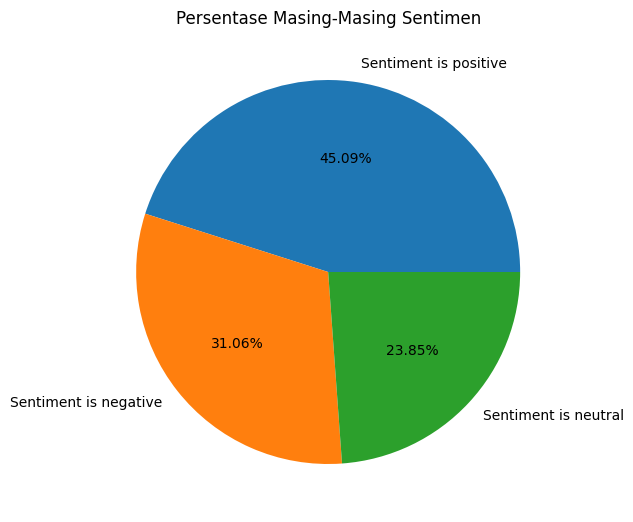

In [59]:
diagram = yc_df["sentimen"].value_counts().rename_axis("nilai_sentimen").reset_index(name = "jumlah")
label = diagram.nilai_sentimen
nilai = diagram.jumlah

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis = ("equal")

# Membentuk pie plot untuk menampilkan persentase masing-masing sentimen
ax.pie(nilai, labels = label, autopct = "%1.2f%%" )
ax.set_title("Persentase Masing-Masing Sentimen")

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import string
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [61]:

# Mendefinisikan jumlah baris untuk komentar negatif
target_num_negatif = 1000

# Menghitung jumlah baris pada komentar negatif yang ada
current_num_negatif = yc_df[yc_df["sentimen"] == "Sentiment is negative"].shape[0]

# Menghitung jumlah tambahan baris komentar negatif yang diperlukan
num_additional_negatif = target_num_negatif - current_num_negatif

# Melakukan oversampling pada komentar negatif jika diperlukan
if num_additional_negatif > 0:
    additional_negatif_samples = yc_df[yc_df["sentimen"] == "Sentiment is negative"].sample(num_additional_negatif, replace=True)
    # Menggabungkan komentar negatif yang asli dengan komentar negatif hasil oversampling
    balanced_data = pd.concat([yc_df, additional_negatif_samples], ignore_index=True)
else:
    balanced_data = yc_df.copy()  # Jika tidak perlu oversampling, salin data aslinya

# Menampilkan jumlah masing-masing sentimen setelah dilakukan oversampling
print(balanced_data["sentimen"].value_counts())


sentimen
Sentiment is positive    1331
Sentiment is negative    1000
Sentiment is neutral      704
Name: count, dtype: int64


In [62]:
X = balanced_data['text_akhir']  # Fitur
y = balanced_data['sentimen']    # Label

In [63]:
# Memisahkan data menjadi fitur (comment) dan label (sentimen)
#X = yc_df['text_akhir']
#y = balanced_data["sentimen"]

In [64]:
#X = yc_df['text_akhir']
#y = yc_df['polarity']

In [65]:
# Ekstraksi fitur dengan Bag of Words (BoW)
tfidf = CountVectorizer()
X_tfidf = tfidf.fit_transform(X)

In [66]:
# Konversi hasil ekstraksi fitur menjadi dataframe
features_df = pd.DataFrame(X_tfidf.toarray(), columns = tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,aak,aamiiin,aamiin,aapaan,abad,abadi,abaikan,abal,abang,abangkubarokah,...,zero,zombie,zonk,𝙺𝚊𝚕𝚘𝚔,𝚊𝚓𝚊,𝚋𝚒𝚜𝚊,𝚐𝚊𝚍𝚊,𝚔𝚘𝚛𝚞𝚙𝚜𝚒,𝚜𝚒𝚑,𝚢𝚐
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Pastikan Anda telah mengimpor semua library yang diperlukan dan data telah diproses

# Memisahkan data menjadi fitur (X) dan label (y)
X = balanced_data['text_akhir']  # Menggunakan data setelah oversampling
y = balanced_data['sentimen']

# Ekstraksi fitur dengan Bag of Words (BoW) menggunakan CountVectorizer
tfidf = CountVectorizer()
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi fitur menjadi dataframe (opsional, jika Anda ingin melihat fitur-fitur)
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())


# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Menampilkan ukuran data latih dan data uji (opsional)
print(f"Data latih: {X_train.shape[0]} baris")
print(f"Data uji: {X_test.shape[0]} baris")


Data latih: 2428 baris
Data uji: 607 baris


In [68]:
# Membuat objek model Random Forest Classifier
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(X_train, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = random_forest_classifier.predict(X_train)
y_pred_test_lr = random_forest_classifier.predict(X_test)

# Evaluasi akurasi model Random Forest Classifier pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Random Forest Classifier pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Random Forest Classifier- accuracy_train:', accuracy_train_lr)
print('Random Forest Classifier - accuracy_test:', accuracy_test_lr)

Random Forest Classifier- accuracy_train: 1.0
Random Forest Classifier - accuracy_test: 0.7512355848434926


In [69]:
# Membuat objek model Random Forest Classifier
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(X_train, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = random_forest_classifier.predict(X_train)
y_pred_test_lr = random_forest_classifier.predict(X_test)

# Evaluasi akurasi model Random Forest Classifier pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Random Forest Classifier pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Random Forest Classifier- accuracy_train:', accuracy_train_lr)
print('Random Forest Classifier - accuracy_test:', accuracy_test_lr)

Random Forest Classifier- accuracy_train: 1.0
Random Forest Classifier - accuracy_test: 0.7512355848434926


In [70]:
# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=10000)

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train)
y_pred_test_lr = logistic_regression.predict(X_test)

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.9855848434925865
Logistic Regression - accuracy_test: 0.7759472817133443


In [71]:
# Membuat objek model Support Vector Machines
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = svm_model.predict(X_train)
y_pred_test_lr = svm_model.predict(X_test)

# Evaluasi akurasi model Support Vector Machines pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Support Vector Machines pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Support Vector Machines - accuracy_train:', accuracy_train_lr)
print('Support Vector Machines - accuracy_test:', accuracy_test_lr)

Support Vector Machines - accuracy_train: 0.9938220757825371
Support Vector Machines - accuracy_test: 0.785831960461285


In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Asumsikan data sudah diproses, X_tfidf adalah fitur dan y adalah label

# 1. Encode label menjadi one-hot encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 2. One-hot encoding untuk label
y_onehot = to_categorical(y_encoded)

# 3. Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_onehot, test_size=0.2, random_state=42)

# 4. Membangun model ANN
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))  # Layer input
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer untuk multi-class

# 5. Kompilasi model dengan optimizer Adam
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 6. Melatih model pada data latih
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# 7. Evaluasi akurasi model pada data latih dan data uji
_, accuracy_train_ann = model.evaluate(X_train, y_train, verbose=0)
_, accuracy_test_ann = model.evaluate(X_test, y_test, verbose=0)

# Menampilkan hasil
print('ANN - accuracy_train:', accuracy_train_ann)
print('ANN - accuracy_test:', accuracy_test_ann)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4310 - loss: 1.0515 - val_accuracy: 0.6293 - val_loss: 0.8376
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7661 - loss: 0.6000 - val_accuracy: 0.7759 - val_loss: 0.6208
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9667 - loss: 0.1705 - val_accuracy: 0.8040 - val_loss: 0.6498
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9947 - loss: 0.0426 - val_accuracy: 0.8056 - val_loss: 0.7324
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9996 - loss: 0.0149 - val_accuracy: 0.8105 - val_loss: 0.7969
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.8040 - val_loss: 0.8571
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.8040 - val_loss: 0.9105
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.8056 - v

In [73]:
# LSTM

In [74]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [75]:
sentiment = pd.get_dummies(yc_df['polarity']).astype(int)
final_yc_df = pd.concat([yc_df, sentiment], axis=1)
final_yc_df = final_yc_df.drop(columns='polarity')

In [76]:
X = final_yc_df['text_akhir'].values
y = final_yc_df[['negative','neutral','positive']].values

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)

(2361,)
(591,)


In [78]:
tokenizer = Tokenizer(num_words=50000, oov_token='')

tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_train)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(sequence_train, padding='post', maxlen=50, truncating='post')
padded_test = pad_sequences(sequence_test, padding='post', maxlen=50, truncating='post')

In [79]:
model = Sequential([
    Embedding(input_dim=50000, output_dim=16, input_length=50),
    Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    LSTM(32),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(3, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [80]:
# Compiling the Model
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005), metrics=['accuracy'])


In [81]:
import tensorflow as tf

# Set epoch Callback
class EpochCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print("Starting epoch {}".format(epoch + 1))

    def on_epoch_end(self, epoch, logs=None):
        print("Finished epoch {}".format(epoch + 1))


In [82]:
import tensorflow as tf

# Set function CheckpointCallback when accuracy > 0.95
class CheckpointCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get("accuracy")
        current_val_accuracy = logs.get("val_accuracy")
        print("Current accuracy is {}".format(current_accuracy))
        print("Current val accuracy is {}".format(current_val_accuracy))
        if current_accuracy > 0.95 and current_val_accuracy > 0.95:
            print("\nAccuracy has reached >95%")
            self.model.stop_training = True


In [83]:
reduce_lrate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    padded_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(padded_test, y_test),
    validation_steps=5,
    callbacks=[EpochCallback(), CheckpointCallback(), reduce_lrate]
)

Starting epoch 1
Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.4459 - loss: 1.0776Finished epoch 1
Current accuracy is 0.44684454798698425
Current val accuracy is 0.48124998807907104
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.4459 - loss: 1.0775 - val_accuracy: 0.4812 - val_loss: 1.0489 - learning_rate: 5.0000e-04
Starting epoch 2
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4612 - loss: 1.0622Finished epoch 2
Current accuracy is 0.44684454798698425
Current val accuracy is 0.4625000059604645
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.4610 - loss: 1.0623 - val_accuracy: 0.4625 - val_loss: 1.0564 - learning_rate: 5.0000e-04
Starting epoch 3
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4508 - loss: 1.0668Finished epoch 3
Current accuracy is 0.44684454798698425
Current val accuracy is 0.4749999940395355
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.4508 - loss: 1.0668 - val_accuracy: 0.4750 - val_l

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Finished epoch 4
Current accuracy is 0.44684454798698425
Current val accuracy is 0.44144144654273987
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.4406 - loss: 1.0721 - val_accuracy: 0.4414 - val_loss: 1.0798 - learning_rate: 5.0000e-04
Starting epoch 5
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.4538 - loss: 1.0694Finished epoch 5
Current accuracy is 0.44684454798698425
Current val accuracy is 0.48124998807907104
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.4537 - loss: 1.0694 - val_accuracy: 0.4812 - val_loss: 1.0504 - learning_rate: 5.0000e-04
Starting epoch 6
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4538 - loss: 1.0571Finished epoch 6
Current accuracy is 0.4459974467754364
Current val accuracy is 0.4437499940395355
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.4537 - loss: 1.0569 - val_accuracy: 0.4437 - val_loss: 1.0265 - learning_rate: 5.0000e-04
Starting epoch 7
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/st

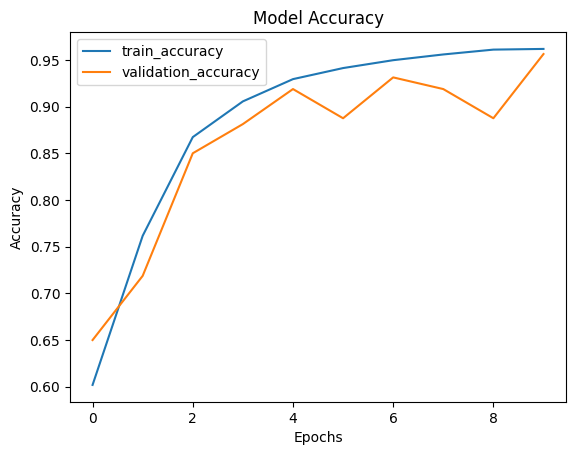

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

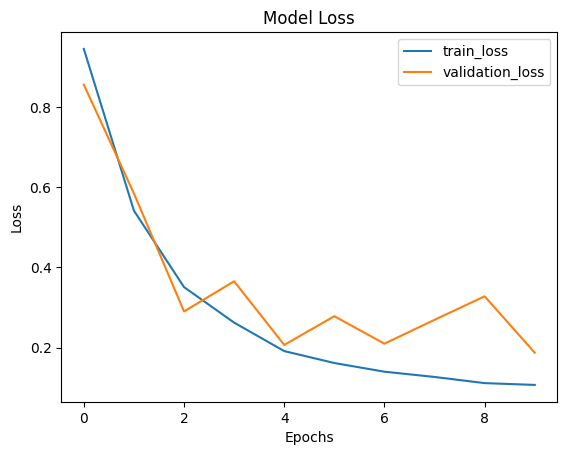

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# 6. Evaluate

In [ ]:
loss, accuracy = model.evaluate(padded_test, y_test)
print(f'Akurasi pada data uji: {accuracy:.4f}')

106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9135 - loss: 0.2956
Akurasi pada data uji: 0.9076


In [ ]:
y_pred = model.predict(padded_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


In [ ]:
# Evaluasi akurasi menggunakan accuracy_score
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Akurasi pada data uji: {accuracy:.4f}')

Akurasi pada data uji: 0.9076


In [ ]:
from sklearn.metrics import classification_report
target_names = ['negative','neutral','positive']
print(classification_report(y_test_classes, y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

    negative       0.80      0.96      0.87       786
     neutral       0.97      0.65      0.78       564
    positive       0.95      0.96      0.95      2028

    accuracy                           0.91      3378
   macro avg       0.91      0.86      0.87      3378
weighted avg       0.92      0.91      0.90      3378



In [ ]:
# Save model

In [ ]:
# Simpan model sentiment analysis
model.save('model_youtube_comments_sentiment_analysis.h5')

In [ ]:
# Simpan tokenizer
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# 9. Load Model & Test Predict Model

In [ ]:
# Fungsi prediksi
def predict_sentiment(text, tokenizer, model):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=50, truncating='post')
    prediction = model.predict(padded_sequence)
    sentiment = ['negative', 'neutral', 'positive']
    return sentiment[np.argmax(prediction)]

In [ ]:
# Memuat model yang telah disimpan
loaded_model = tf.keras.models.load_model('model_youtube_comments_sentiment_analysis.h5')

In [ ]:
# load tokenizer
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
# Contoh penggunaan test random dengan input text sendiri
text_sample = "saya suka menggunakan iconnect"
predicted_sentiment = predict_sentiment(text_sample, tokenizer, loaded_model)
print(f'Sentimen dari teks contoh: {predicted_sentiment}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
Sentimen dari teks contoh: positive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!pip install pipreqs


In [ ]:
!pipreqsnb /content/drive/MyDrive --force


/bin/bash: line 1: pipreqsnb: command not found


In [ ]:
!pipreqsnb /content/drive/MyDrive/notebooks --force


/bin/bash: line 1: pipreqsnb: command not found


In [ ]:
!pipreqsnb /content/drive/MyDrive --force


/bin/bash: line 1: pipreqsnb: command not found


In [ ]:
!pip install --upgrade pip
!pip install pipreqsnb


  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Preparing metadata (setup.py) ... done
  Created wheel for pipreqsnb: filename=pipreqsnb-0.2.4-py3-none-any.whl size=4128 sha256=aa8536f5f52d73a238fd0a94c890dd115ad6e70be2f567ceca580a1178d10e01
  Stored in directory: /root/.cache/pip/wheels/c3/1b/47/ca78a979321cb4bf9e812da5157fb754712f43d094bc60bf61
Successfully built pipreqsnb


In [ ]:
!pip freeze > /content/drive/MyDrive/Colab/requirements.txt